In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools

In [92]:
data = pd.read_csv('/content/Stroke_Dataset.csv')
data = data.rename(columns={'avg_glucose_level': 'glu'})
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,glu,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [93]:
from sklearn.model_selection import train_test_split

# Split the original dataset into train and test sets (80:20 ratio)
train, test = train_test_split(
    data,
    test_size=0.2,
    random_state=42,
    stratify=data['stroke'] # Stratify by the 'stroke' column to preserve the class distribution in both sets
)


# I. Exploratory Data Analysis (EDA)

## 1. Overview

In [94]:
print("Stroke Prediction Dataset has {} rows, {} columns.".format(data.shape[0], data.shape[1]))
print("After splitting with 8:2 ratio, train dataset has {} rows and test dataset has {} rows.".format(train.shape[0], test.shape[0]))


Stroke Prediction Dataset has 5110 rows, 12 columns.
After splitting with 8:2 ratio, train dataset has 4088 rows and test dataset has 1022 rows.


In [95]:
# Create a DataFrame to store null counts for train and test sets
null_counts = pd.DataFrame({
    'feature': train.columns,
    'Train_NULL_count': train.isnull().sum().values,
    'Test_NULL_count': test.isnull().sum().values
})

# Display the table
display(null_counts)

,feature,Train_NULL_count,Test_NULL_count
0,id,0,0
1,gender,0,0
2,age,0,0
3,hypertension,0,0
4,heart_disease,0,0
5,ever_married,0,0
6,work_type,0,0
7,Residence_type,0,0
8,glu,0,0
9,bmi,170,31


In both the train and test sets, only the feature 'bmi' has missing values.

In [96]:
# Create a table containing features and their unique values
unique_values = pd.DataFrame({
    'feature': train.columns,
    'unique_values': [train[col].unique() for col in train.columns]
})

# Display the table
display(unique_values)

,feature,unique_values
0,id,"[25283, 43734, 47113, 56996, 26325, 67159, 521..."
1,gender,"[Female, Male, Other]"
2,age,"[48.0, 15.0, 67.0, 44.0, 14.0, 73.0, 63.0, 42...."
3,hypertension,"[0, 1]"
4,heart_disease,"[0, 1]"
5,ever_married,"[Yes, No]"
6,work_type,"[Private, Self-employed, Govt_job, children, N..."
7,Residence_type,"[Urban, Rural]"
8,glu,"[69.21, 122.25, 110.42, 65.41, 82.34, 71.29, 1..."
9,bmi,"[33.1, 21.0, 24.9, 24.8, 31.6, 37.7, 44.5, 38...."




*   There are only 4 numerical columns: id, age, glu, bmi
*   The 'id' feature is a patient identifier rather than a predictive variable for machine learning models, so it will be considered for removal.



In [97]:
# Define numerical columns (excluding 'id')
num_col = ['age', 'glu', 'bmi']

# Define categorical columns (all other columns except 'id' and num_col)
cat_col = [col for col in train.columns if col not in num_col + ['id', 'stroke']]

print("Here are all the numerical columns: ", num_col)
print("The rest are categorical columns: ", cat_col)
print("The 'id' column will be removed. And the 'stroke' column is the target variable.")

Here are all the numerical columns:  ['age', 'glu', 'bmi']
The rest are categorical columns:  ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
The 'id' column will be removed. And the 'stroke' column is the target variable.


## 2. Univariate Analysis

### 2.1 Numerical columns

In [98]:
train[num_col].describe()

,age,glu,bmi
count,4088.000000,4088.000000,3918.000000
mean,43.353288,106.317167,28.922180
std,22.596816,45.259652,7.928378
min,0.080000,55.120000,10.300000
25%,26.000000,77.312500,23.600000
50%,45.000000,91.945000,28.000000
75%,61.000000,114.197500,33.100000
max,82.000000,271.740000,97.600000


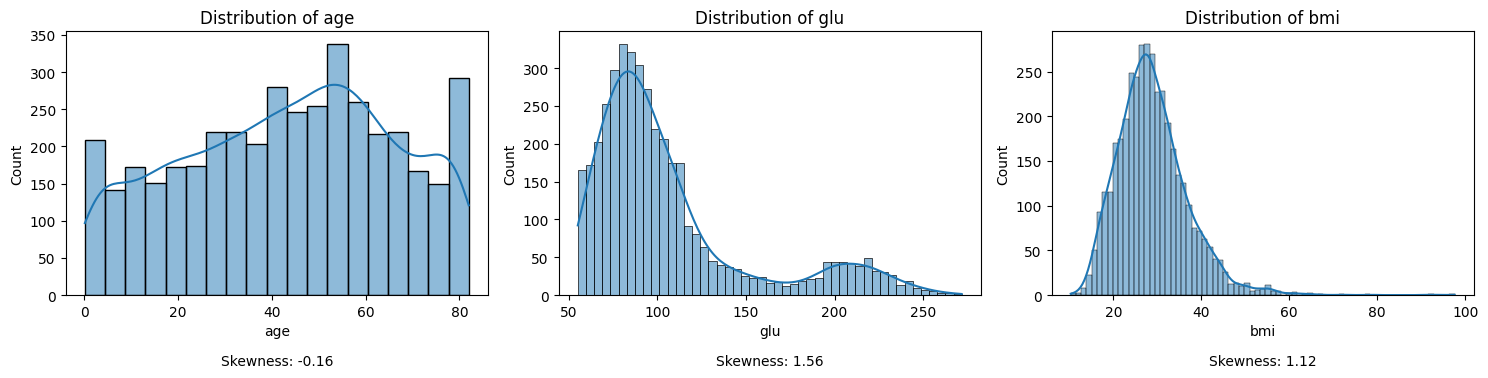

In [99]:
fig, axes = plt.subplots(1, len(num_col), figsize=(5*len(num_col), 4))

for i, col in enumerate(num_col):
    # Histogram + KDE
    sns.histplot(train[col].dropna(), kde=True, ax=axes[i])

    # Skewness
    skew_val = train[col].skew()

    # Title
    axes[i].set_title(f"Distribution of {col}")

    # Print Skewness below
    axes[i].text(
        0.5, -0.25,
        f"Skewness: {skew_val:.2f}",
        ha='center', va='center', transform=axes[i].transAxes
    )

plt.tight_layout()
plt.show()

* age – skew = -0.16: approximately symmetric, negligible left skewness
* glu – skew = 1.56: considerably right-skewed
* bmi – skew = 1.12: moderately right-skewed, requires careful consideration



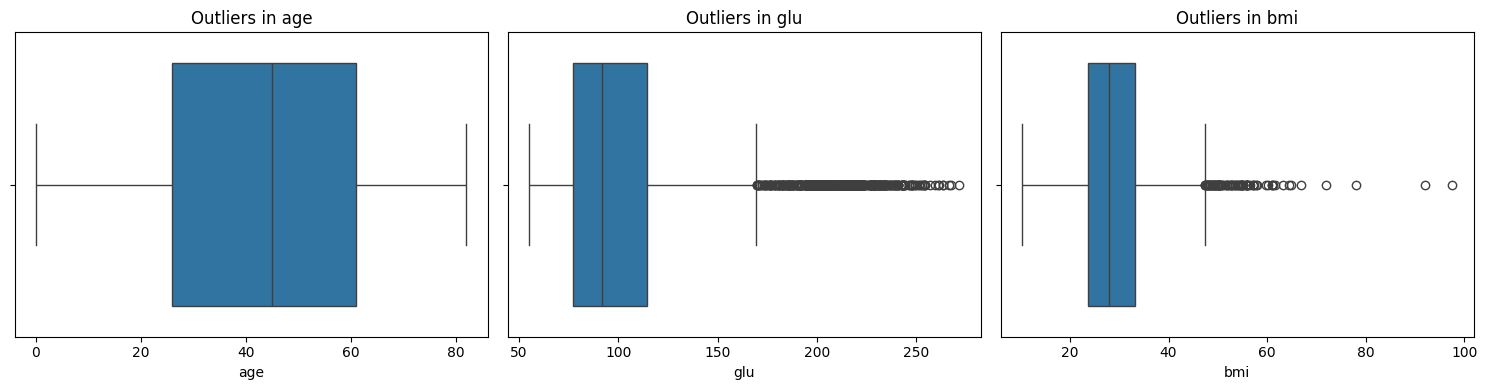

In [100]:
fig, axes = plt.subplots(1, len(num_col), figsize=(5*len(num_col), 4))

for i, col in enumerate(num_col):
    sns.boxplot(x=train[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

plt.tight_layout()
plt.show()

* Age: no outliers
* BMI: outliers detected
* Glucose: a large number of outliers detected

#### About glu outlier

In [101]:
Q1 = train['glu'].quantile(0.25)
Q3 = train['glu'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
print("Upper bound for glu outliers:", upper_bound)

Upper bound for glu outliers: 169.525


In [102]:
num_stroke = train[train['stroke'] == 1].shape[0]
print("Number of people with stroke in train:", num_stroke)

num_stroke_out = train[(train['stroke'] == 1) & (train['glu'] >= upper_bound)].shape[0]
print("Number of people with stroke and glucose above the outlier threshold in train is {}, accounting for {:.3f} %".format(
    num_stroke_out, 100 * num_stroke_out / num_stroke))


Number of people with stroke in train: 199
Number of people with stroke and glucose above the outlier threshold in train is 66, accounting for 33.166 %


### 2.2 Categorical columns

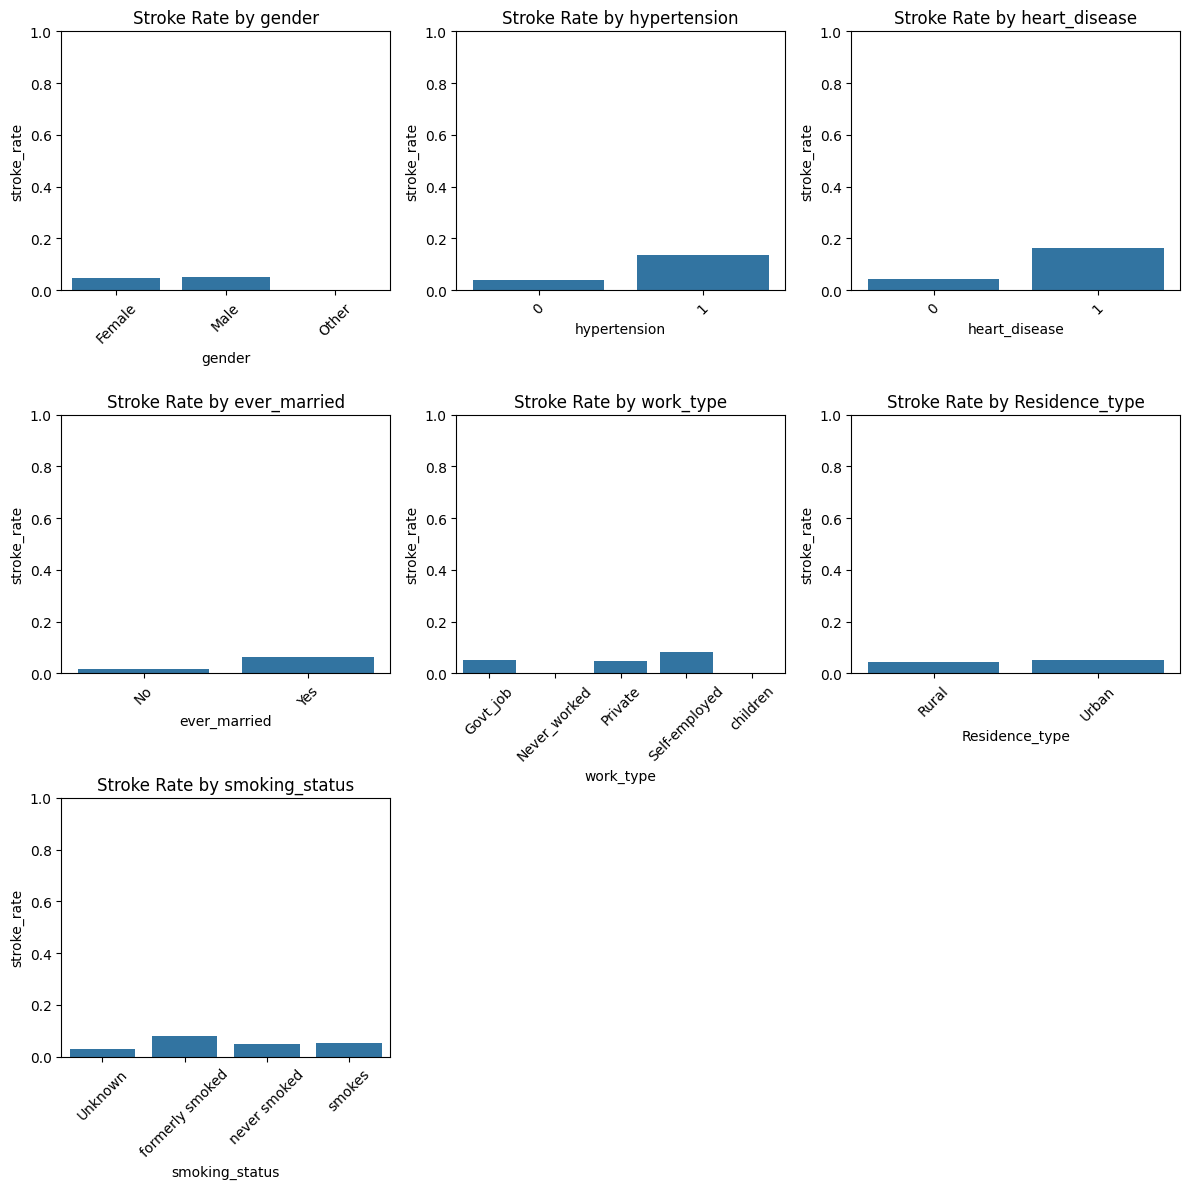

In [103]:
n_col_per_row = 3
n_row = math.ceil(len(cat_col) / n_col_per_row)

plt.figure(figsize=(4*n_col_per_row, 4*n_row))

for i, col in enumerate(cat_col):
    plt.subplot(n_row, n_col_per_row, i+1)
    stroke_ratio = train.groupby(col)['stroke'].mean().reset_index()
    stroke_ratio.columns = [col, 'stroke_rate']
    sns.barplot(x=col, y='stroke_rate', data=stroke_ratio)
    plt.title(f'Stroke Rate by {col}')
    plt.ylim(0,1)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Below, for each feature, the categories are sorted in ascending order of stroke rate:
* gender: Other - Female - Male
* hypertension: 0 - 1
* heart_disease: 0 - 1
* ever_married: No - Yes
* work_type: children - Never_worked - Private - Govt_job - Self-employed
* Residence_type: Rural - Urban
* smoking_status: Unknown - never smoked - smokes - formerly smoked

#### About "Other" gender

In [104]:
num_other = train[train['gender'] == 'Other'].shape[0]
print("Number of people with 'Other' gender is:", num_other)

Number of people with 'Other' gender is: 1


### 2.3 Targeted Variable

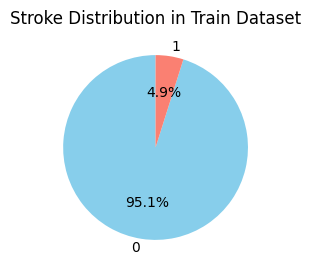

In [105]:
stroke_counts = train['stroke'].value_counts()

plt.figure(figsize=(3,3))
plt.pie(stroke_counts,
        labels=stroke_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['skyblue', 'salmon'])
plt.title('Stroke Distribution in Train Dataset')
plt.show()

Only 4.9% of people (label 1) in the training dataset have had a stroke, which clearly shows that the dataset is heavily imbalanced.

## Multivariate Analysis

### Heatmap

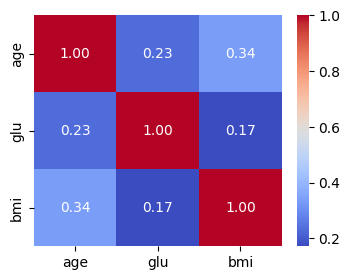

In [106]:
corr = train[num_col].corr()

plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.show()

In the heatmap, the linear correlations between the pairs of variables do not exceed 0.35, which indicates rather weak relationships. Therefore, it is not necessary to consider removing any features at this stage.

### Scatter plot

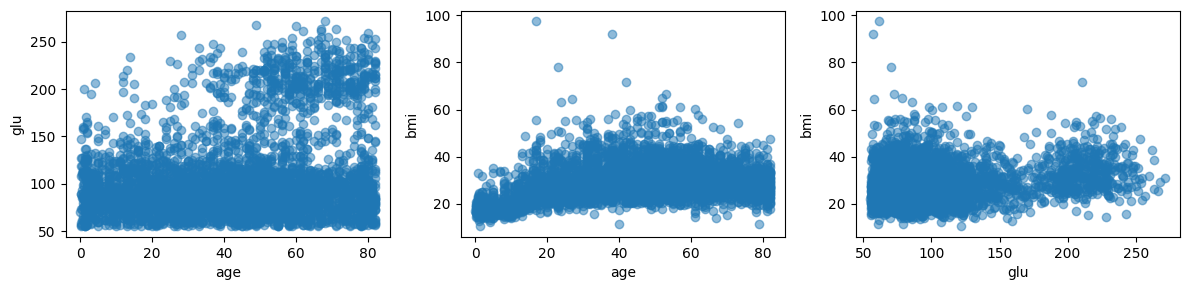

In [107]:
cols = num_col
n = len(cols)

pairs = list(itertools.combinations(range(n), 2))
total_plots = len(pairs)

plt.figure(figsize=(4*total_plots, 3))

for plot_num, (i, j) in enumerate(pairs, 1):
    plt.subplot(1, total_plots, plot_num)  # 1 hàng, total_plots cột
    plt.scatter(train[cols[i]], train[cols[j]], alpha=0.5)
    plt.xlabel(cols[i])
    plt.ylabel(cols[j])

plt.tight_layout()
plt.show()

The data points are quite widely dispersed and there is no strong linear trend between the pairs of variables.

### Stacked bar chart

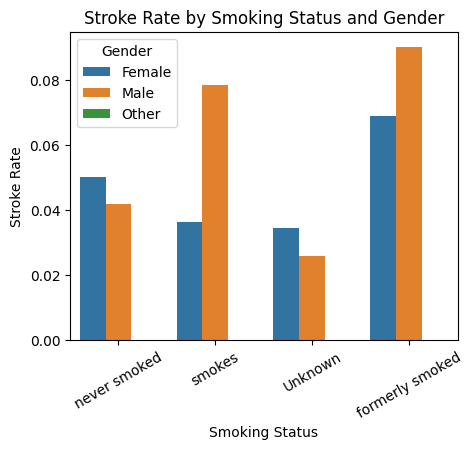

In [108]:
plt.figure(figsize=(5,4))
sns.barplot(
    data=train,
    x="smoking_status",
    y="stroke",
    hue="gender",
    estimator=lambda x: sum(x)/len(x),
    errorbar=None
)

plt.title("Stroke Rate by Smoking Status and Gender")
plt.ylabel("Stroke Rate")
plt.xlabel("Smoking Status")
plt.legend(title="Gender")
plt.xticks(rotation=30)
plt.show()

This suggests that smoking habits have a significant impact on the stroke rate, and this effect differs between males and females.

# II. Data Preprocessing and Feature Engineering

## Drop 'id'

In [109]:
train = train.drop(columns=["id"])
test = test.drop(columns=["id"])

## NULL and outlier handling for 'bmi'

In [110]:
bmi_mean = train['bmi'].mean()
print("Mean BMI in train:", bmi_mean)
train['bmi'] = train['bmi'].fillna(bmi_mean)
test['bmi'] = test['bmi'].fillna(bmi_mean)

Mean BMI in train: 28.922179683512


In [116]:
Q1_bmi = train['bmi'].quantile(0.25)
Q3_bmi = train['bmi'].quantile(0.75)
IQR_bmi = Q3_bmi - Q1_bmi
upper_bmi = Q3_bmi + 1.5 * IQR_bmi
print("Upper bound for BMI outliers:", upper_bmi)

Upper bound for BMI outliers: 46.29999999999999


In [117]:
train['bmi'] = train['bmi'].clip(upper=upper_bmi)
test['bmi'] = test['bmi'].clip(upper=upper_bmi)

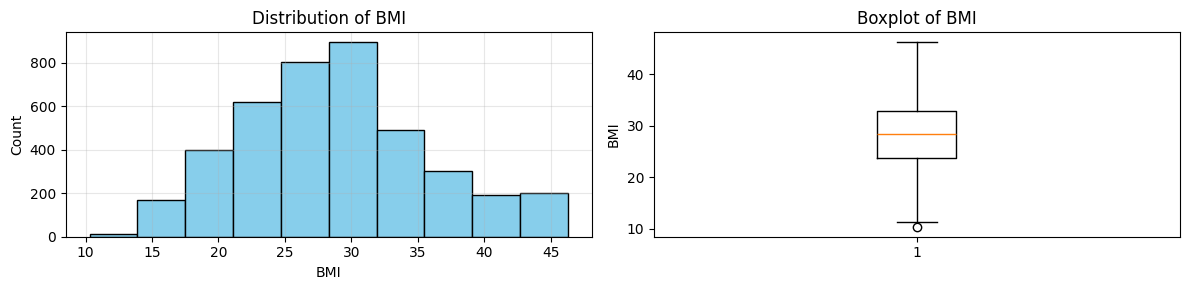

In [121]:
plt.figure(figsize=(12, 3))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(train['bmi'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(train['bmi'])
plt.title('Boxplot of BMI')
plt.ylabel('BMI')

plt.tight_layout()
plt.show()

Looking good!

## Handling right-skewness for 'glu'

In [122]:
train['glu'] = np.log(train['glu'] + 1)
test['glu'] = np.log(test['glu'] + 1)

## 'gender'

In [123]:
train['gender'] = train['gender'].replace('Other', 'Male')
test['gender'] = test['gender'].replace('Other', 'Male')

## Targeted Ordinal Encoding

In [125]:
encoding_dict = {
    "gender": {"Female": 1, "Male": 2},
    "hypertension": {0: 1, 1: 2},
    "heart_disease": {0: 1, 1: 2},
    "ever_married": {"No": 1, "Yes": 2},
    "work_type": {"children": 1, "Never_worked": 2, "Private": 3, "Govt_job": 4, "Self-employed": 5},
    "Residence_type": {"Rural": 1, "Urban": 2},
    "smoking_status": {"Unknown": 1, "never smoked": 2, "smokes": 3, "formerly smoked": 4}
}

In [126]:
for col, mapping in encoding_dict.items():
    train[col] = train[col].map(mapping)
    test[col] = test[col].map(mapping)

## Scale

In [130]:
quartiles = pd.DataFrame({
    'Q1': train.drop(columns=['stroke']).quantile(0.25),
    'Q2': train.drop(columns=['stroke']).quantile(0.5),
    'Q3': train.drop(columns=['stroke']).quantile(0.75)
})

quartiles.index.name = 'Feature'

print(quartiles)

                       Q1         Q2         Q3
Feature                                        
gender           1.000000   1.000000   2.000000
age             26.000000  45.000000  61.000000
hypertension     1.000000   1.000000   1.000000
heart_disease    1.000000   1.000000   1.000000
ever_married     1.000000   2.000000   2.000000
work_type        3.000000   3.000000   4.000000
Residence_type   1.000000   2.000000   2.000000
glu              4.360707   4.532008   4.746648
bmi             23.800000  28.400000  32.800000
smoking_status   1.000000   2.000000   3.000000


In [132]:
features_to_scale = train.drop(columns=['stroke']).columns
print(features_to_scale)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'glu', 'bmi', 'smoking_status'],
      dtype='object', name='Feature')


In [133]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train[features_to_scale] = scaler.fit_transform(train[features_to_scale])
test[features_to_scale] = scaler.transform(test[features_to_scale])

# III. Recheck

In [139]:
train.head(5)

Feature,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,glu,bmi,smoking_status,stroke
845,0.0,0.085714,0.0,0.0,0.0,0.0,0.0,-0.726840,0.522222,0.0,0
3744,1.0,-0.857143,0.0,0.0,-1.0,0.0,-1.0,0.731218,-0.822222,0.0,0
4183,0.0,0.628571,0.0,0.0,0.0,2.0,-1.0,0.469758,-0.388889,0.0,0
3409,1.0,-0.028571,0.0,0.0,0.0,0.0,0.0,-0.871015,-0.400000,0.5,0
284,1.0,-0.885714,0.0,0.0,-1.0,1.0,0.0,-0.282632,0.355556,-0.5,0


In [140]:
test.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,glu,bmi,smoking_status,stroke
3725,1.0,0.514286,0.0,0.0,0.0,0.0,-1.0,-0.413672,0.711111,0.0,0
4481,0.0,-0.057143,0.0,0.0,0.0,0.0,0.0,-0.151391,0.544444,0.0,0
1545,0.0,-0.628571,0.0,0.0,-1.0,0.0,0.0,0.822512,0.033333,0.5,0
1820,0.0,-0.685714,0.0,0.0,-1.0,0.0,0.0,2.101720,-0.388889,0.0,0
1262,1.0,0.628571,0.0,0.0,0.0,0.0,-1.0,0.536788,-0.233333,1.0,0


In [141]:
null_counts_1 = pd.DataFrame({
    'feature': train.columns,
    'Train_NULL_count': train.isnull().sum().values,
    'Test_NULL_count': test.isnull().sum().values
})

display(null_counts_1)

,feature,Train_NULL_count,Test_NULL_count
0,gender,0,0
1,age,0,0
2,hypertension,0,0
3,heart_disease,0,0
4,ever_married,0,0
5,work_type,0,0
6,Residence_type,0,0
7,glu,0,0
8,bmi,0,0
9,smoking_status,0,0


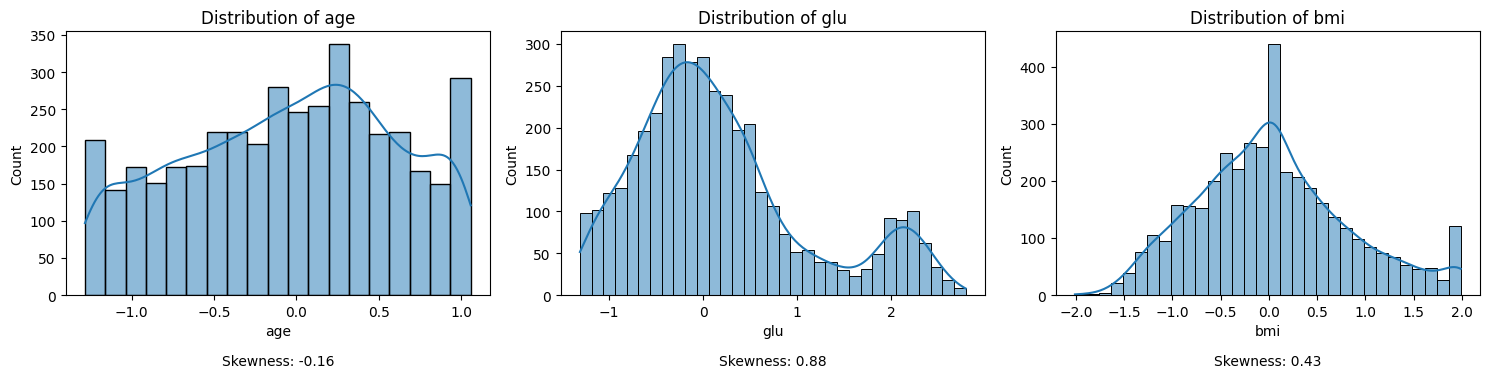

In [142]:
fig, axes = plt.subplots(1, len(num_col), figsize=(5*len(num_col), 4))

for i, col in enumerate(num_col):
    # Histogram + KDE
    sns.histplot(train[col].dropna(), kde=True, ax=axes[i])

    # Skewness
    skew_val = train[col].skew()

    # Title
    axes[i].set_title(f"Distribution of {col}")

    # Print Skewness below
    axes[i].text(
        0.5, -0.25,
        f"Skewness: {skew_val:.2f}",
        ha='center', va='center', transform=axes[i].transAxes
    )

plt.tight_layout()
plt.show()

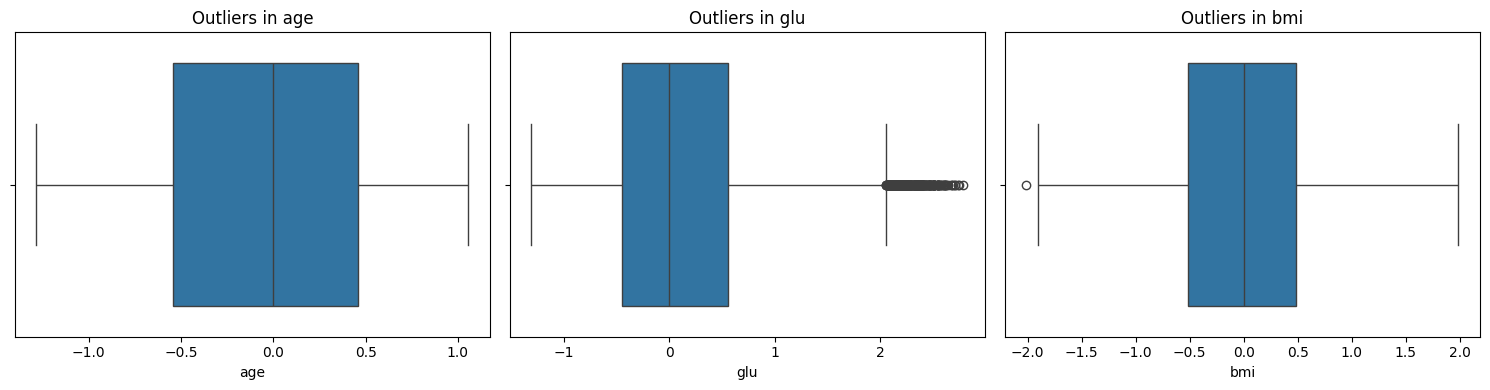

In [143]:
fig, axes = plt.subplots(1, len(num_col), figsize=(5*len(num_col), 4))

for i, col in enumerate(num_col):
    sns.boxplot(x=train[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

plt.tight_layout()
plt.show()

Looking good, ready for machine learning!

# Handling unbalanced data and exporting it for experiments

In [145]:
train.to_csv('Train_processed_noSMOTE.csv', index=False)
test.to_csv('Test_processed.csv', index=False)

In [151]:
from imblearn.over_sampling import SMOTE
X_train = train.drop(columns=['stroke'])
y_train = train['stroke']
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
train_smote = pd.DataFrame(X_res, columns=X_train.columns)
train_smote['stroke'] = y_res

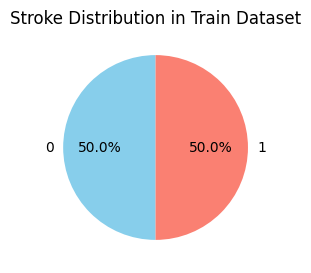

In [154]:
stroke_counts_1 = train_smote['stroke'].value_counts()

plt.figure(figsize=(3,3))
plt.pie(stroke_counts_1,
        labels=stroke_counts_1.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['skyblue', 'salmon'])
plt.title('Stroke Distribution in Train Dataset')
plt.show()

In [155]:
train_smote.to_csv('Train_processed_wSMOTE.csv', index=False)